In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import timeit
import matplotlib.patches as patches
import sys
from copy import deepcopy

# MCTS code imports
sys.path.append("..")  # Adds higher directory to python modules path.
from car import Car
from utils import wrapped_angle_diff, new_wrapped_angle_diff

In [4]:
def get_rectangle_points(mean, length=2, width=1):
    return np.array([
        [mean[0] - length/2, mean[1] - width/2],
        [mean[0] + length/2, mean[1] - width/2],
        [mean[0] + length/2, mean[1] + width/2],
        [mean[0] - length/2, mean[1] + width/2]
    ])
    
# Create two rectangles using mean
rect1 = get_rectangle_points([-5, 2])
rect2 = get_rectangle_points([3, -4])

# Close them for plotting by adding the first point to the end
rect1_closed = np.concatenate([rect1, [rect1[0]]])
rect2_closed = np.concatenate([rect2, [rect2[0]]])

# Create a car using mean
car = np.array([0,-5])

# Create a KDTree and insert points from the two rectangles
points = np.concatenate([rect1, rect2])
tree = KDTree(points)

In [5]:
# near_point_indeces = tree.query_ball_point(car, 5)
# points = tree.data[near_point_indeces]
# print(points)

# # tree.data
tree_query = tree.query(car, k=10, distance_upper_bound=9)

# Construct an array of rows (x,y, distance) for each point
non_inf_len = np.shape(tree_query[0][tree_query[0] != np.inf])[0] # Length of non-inf points
xy_points = tree.data[tree_query[1][:non_inf_len]]

Num corners in range: 6
Num obstacles in range: 0
Corner reward: 1960.0013288453938
Obstacle reward: -0.0

Num corners in range: 6
Num obstacles in range: 0
Corner reward: 1244.0280226183477
Obstacle reward: -0.0

Num corners in range: 6
Num obstacles in range: 0
Corner reward: 511.5012824787997
Obstacle reward: -0.0

Num corners in range: 6
Num obstacles in range: 1
Corner reward: 231.88937825722672
Obstacle reward: -7.892734780932479

Evaluation time taken: 0.046477 seconds


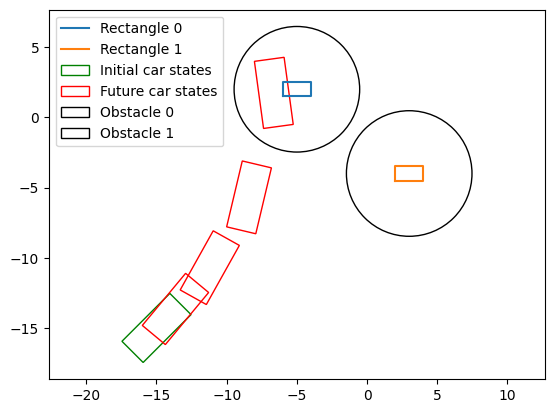

In [7]:
def get_car_patch(car, label, color):
    car_poly = car.get_collision_polygon()
    return patches.Polygon(np.array(car_poly.exterior.coords), closed=True, fill=None, label=label, color=color)

def get_evaluation_kd_tree(oois, std_devs=3):
    # Create needed vectors
    kd_tree_pts = np.zeros((len(oois) * 5, 2)) # 4 corner points + mean obstacle point rows and (x, y) columns
    obs_radii = np.zeros((len(oois), 1)) # Radius of obstacle (based on std deviation)
    
    # First calculate circular obstacles at mean of oois
    for i, ooi in enumerate(oois):
        mean = np.mean(ooi, axis=0) # Calculate mean of ooi corners
        std_dev = std_devs * np.std(ooi, axis=0) # Calculate std deviation of ooi corners scaled by std_devs
        
        # Add obstacle mean to points for kd tree (beginning is for obstacles)
        kd_tree_pts[i, :] = mean
        obs_radii[i] = np.linalg.norm(std_dev) # Calculate radius of obstacle
        
    # Add ooi corner points to kd tree
    # Stack the oois list into a numpy array
    ooi_stacked = np.vstack(oois)
    kd_tree_pts[len(oois):, :] = ooi_stacked

    # Create a KDTree from the points
    tree = KDTree(kd_tree_pts)
    
    # Return the tree and obstacle radii
    return tree, obs_radii.flatten()

def get_nearest_points(tree, point, radius):
    # Find all points within the radius of the point (returns points sorted by distance and their indeces)
    distances, indeces = tree.query(point, k=8, distance_upper_bound=radius)
    
    # Find the length of the non-infinite points
    non_inf_len = np.shape(distances[distances != np.inf])[0] # Length of non-inf points
    
    # Remove points with infinite distance (which have index larger than kd tree size)
    distances = distances[:non_inf_len]
    indeces = indeces[:non_inf_len]
    
    return distances, indeces
    
def get_evaluation_reward(kd_tree, obstacle_radii, car, corner_scale=1, obstacle_scale=1):
    # Query the KDTree to find points within the car max range
    dists, indeces = get_nearest_points(kd_tree, car.state[:2], car.max_range)
    
    # Order the distances and indeces to have increasing index
    ordered_dists = dists[np.argsort(indeces)]
    ordered_indeces = indeces[np.argsort(indeces)]
    
    # Now find the number of obstacle points in the near indeces
    obs_pts_count = np.sum(ordered_indeces < len(obstacle_radii)) # returns number of True values
    
    # Now we can split the ordered indeces and distances into obstacle and corner vectors
    obs_indices = ordered_indeces[:obs_pts_count]
    obs_dists = ordered_dists[:obs_pts_count]
    corner_indices = ordered_indeces[obs_pts_count:]
    corner_dists = ordered_dists[obs_pts_count:]
    
    # Now we can calculate the reward based on the distances to the corners
    corner_reward = corner_scale * np.sum(corner_dists**2) # * corner_traces
    
    # Only take the points that are within the obstacle radii
    close_obs_indices = obs_indices[obs_dists < obstacle_radii[obs_indices]]
    close_obs_dists = obs_dists[obs_dists < obstacle_radii[obs_indices]]
    
    # And the punishment for being within the obstacle radii
    obs_reward = -obstacle_scale * np.sum((obstacle_radii[close_obs_indices] - close_obs_dists)**2)
    
    print(f'Num corners in range: {len(corner_indices)}')
    print(f'Num obstacles in range: {len(close_obs_indices)}')
    print(f'Corner reward: {corner_reward}')
    print(f'Obstacle reward: {obs_reward}')
    print()
    
def run_evaluation(dt, num_steps, action, car, ooi_points, kd_tree, obs_radii, plot=True):
    if plot:
        fig, ax = plt.subplots()
        plt.axis('equal')
        
        for i, pt_arr in enumerate(ooi_points):
            ax.plot(pt_arr[:,0], pt_arr[:,1], label=f'Rectangle {i}')
        
        # Plot initial car state
        ax.add_patch(get_car_patch(car,'Initial car states', color='g'))
    
    # Loop and plot actions
    for i in range(num_steps):
        # Update the car state
        car.update(dt, action)
        
        if plot:
            if i == 0:
                ax.add_patch(get_car_patch(car,'Future car states', 'r'))
            else:
                ax.add_patch(get_car_patch(car,None, 'r'))

        # Calculate the reward only for the final state
        get_evaluation_reward(kd_tree, obs_radii, car)

    if plot:
        # Plot the obstacle circles using the radii
        for i, radius in enumerate(obs_radii):
            ax.add_patch(patches.Circle(kd_tree.data[i], radius, fill=None, label=f'Obstacle {i}'))

        plt.legend()
  
# Create two rectangles using mean
rect1 = get_rectangle_points([-5, 2])
rect2 = get_rectangle_points([3, -4])

# Close them for plotting by adding the first point to the end
rect1_closed = np.concatenate([rect1, [rect1[0]]])
rect2_closed = np.concatenate([rect2, [rect2[0]]])

# Create a car object [X, Y, vx, yaw, steering_angle, steering_angle_rate]
car = Car(None, np.array([-15., -15., 0., np.radians(45), np.radians(8), 0]))

# Calculate kd tree and obstacle radii
kd_tree, obs_radii = get_evaluation_kd_tree([rect1, rect2], std_devs=4)

start_time = timeit.default_timer()
run_evaluation(0.8, 4, np.array([1., 0.]), car, [rect1_closed, rect2_closed], kd_tree, obs_radii, plot=True)
time_taken = timeit.default_timer() - start_time
print(f'Evaluation time taken: {time_taken:.6f} seconds')

In [2]:
def test_wrapped_angle_diff():
    angles = np.linspace(-4 * np.pi, 4 * np.pi, 1000)
    
    for angle1 in angles:
        for angle2 in angles:
            original_diff = wrapped_angle_diff(angle1, angle2)
            vectorized_diff = new_wrapped_angle_diff(np.array([angle1]), np.array([angle2]))[0]
            
            assert np.isclose(original_diff, vectorized_diff), f"Mismatch: {original_diff} != {vectorized_diff} for angles {angle1}, {angle2}"
    
    # Test with arrays
    angle1_array = np.random.uniform(-4 * np.pi, 4 * np.pi, 100)
    angle2_array = np.random.uniform(-4 * np.pi, 4 * np.pi, 100)
    
    original_diffs = [wrapped_angle_diff(a1, a2) for a1, a2 in zip(angle1_array, angle2_array)]
    vectorized_diffs = new_wrapped_angle_diff(angle1_array, angle2_array)
    
    assert np.allclose(original_diffs, vectorized_diffs), f"Array mismatch: {original_diffs} != {vectorized_diffs}"

    print("All tests passed!")

# Run the test function
test_wrapped_angle_diff()

All tests passed!
